<a href="https://colab.research.google.com/github/zeliz22/Facial-Expression/blob/main/BasicModelCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!  pip install kaggle
! pip install wandb
!wandb login

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zeliz22 (zeliz22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zazaelizbarashvili","key":"3422f18d69545d5f43297b0e7bfb79f8"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip


 89% 254M/285M [00:00<00:00, 826MB/s] 
100% 285M/285M [00:00<00:00, 853MB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


Using device: cuda
Training data shape: (28709, 2)
Test data shape: (7178, 1)
Unique emotions: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]

Emotion distribution:
0 (Angry): 3995
1 (Disgust): 436
2 (Fear): 4097
3 (Happy): 7215
4 (Sad): 4830
5 (Surprise): 3171
6 (Neutral): 4965


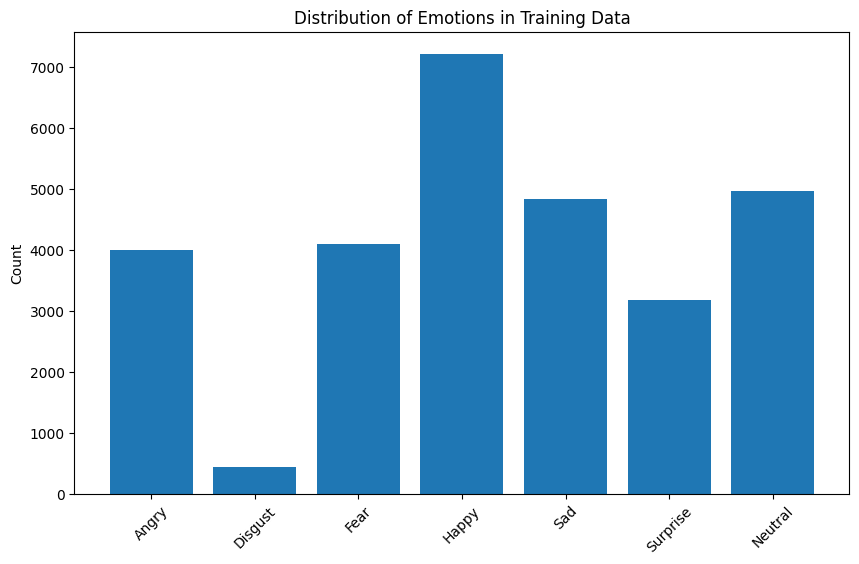

In [5]:
# Cell 1: Setup and Data Loading
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the data
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Unique emotions: {sorted(train_df['emotion'].unique())}")

# Check class distribution
emotion_counts = train_df['emotion'].value_counts().sort_index()
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
print("\nEmotion distribution:")
for i, count in emotion_counts.items():
    print(f"{i} ({emotion_labels[i]}): {count}")

# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.bar(range(7), emotion_counts.values)
plt.xticks(range(7), emotion_labels, rotation=45)
plt.title('Distribution of Emotions in Training Data')
plt.ylabel('Count')
plt.show()

Training samples: 22967
Validation samples: 5742


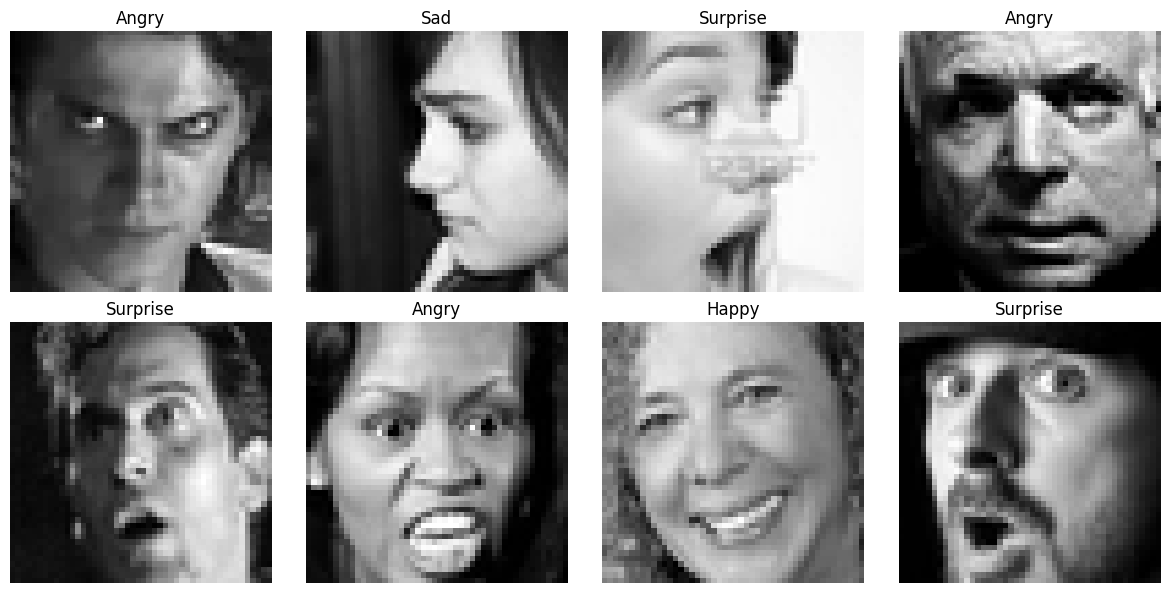

In [6]:
# Cell 2: Data Preprocessing and Dataset Class

def preprocess_pixels(pixel_string):
    """Convert pixel string to numpy array and normalize"""
    pixels = np.array(pixel_string.split(), dtype=np.float32)
    pixels = pixels.reshape(48, 48)
    # Normalize to [0, 1]
    pixels = pixels / 255.0
    return pixels

class FERDataset(Dataset):
    def __init__(self, df, is_test=False, transform=None):
        self.df = df
        self.is_test = is_test
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get pixels
        pixels = preprocess_pixels(self.df.iloc[idx]['pixels'])

        # Convert to tensor and add channel dimension
        image = torch.FloatTensor(pixels).unsqueeze(0)  # Shape: (1, 48, 48)

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image
        else:
            label = torch.LongTensor([self.df.iloc[idx]['emotion']])[0]
            return image, label

# Create train-validation split
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['emotion'])

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

# Visualize some samples
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    sample_idx = np.random.randint(0, len(train_data))
    pixels = preprocess_pixels(train_data.iloc[sample_idx]['pixels'])
    emotion = train_data.iloc[sample_idx]['emotion']

    axes[i].imshow(pixels, cmap='gray')
    axes[i].set_title(f'{emotion_labels[emotion]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Create datasets
train_dataset = FERDataset(train_data.reset_index(drop=True))
val_dataset = FERDataset(val_data.reset_index(drop=True))
test_dataset = FERDataset(test_df, is_test=True)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Cell 3: Basic CNN Model (Baseline)

class BasicCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(BasicCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, num_classes)

        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Conv layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))  # 48x48 -> 24x24
        x = self.pool(F.relu(self.conv2(x)))  # 24x24 -> 12x12
        x = self.pool(F.relu(self.conv3(x)))  # 12x12 -> 6x6

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x



Training Basic CNN Model...
Model parameters: 2,456,071


Epoch 1/15: 100%|██████████| 359/359 [00:17<00:00, 20.93it/s]


Epoch [1/15], Loss: 1.7387, Val Accuracy: 38.49%


Epoch 2/15: 100%|██████████| 359/359 [00:15<00:00, 23.14it/s]


Epoch [2/15], Loss: 1.5361, Val Accuracy: 44.41%


Epoch 3/15: 100%|██████████| 359/359 [00:15<00:00, 22.50it/s]


Epoch [3/15], Loss: 1.4149, Val Accuracy: 49.01%


Epoch 4/15: 100%|██████████| 359/359 [00:15<00:00, 22.71it/s]


Epoch [4/15], Loss: 1.3210, Val Accuracy: 50.78%


Epoch 5/15: 100%|██████████| 359/359 [00:15<00:00, 23.19it/s]


Epoch [5/15], Loss: 1.2395, Val Accuracy: 52.89%


Epoch 6/15: 100%|██████████| 359/359 [00:16<00:00, 21.80it/s]


Epoch [6/15], Loss: 1.1594, Val Accuracy: 54.25%


Epoch 7/15: 100%|██████████| 359/359 [00:15<00:00, 23.14it/s]


Epoch [7/15], Loss: 1.0869, Val Accuracy: 55.29%


Epoch 8/15: 100%|██████████| 359/359 [00:15<00:00, 23.11it/s]


Epoch [8/15], Loss: 1.0194, Val Accuracy: 55.45%


Epoch 9/15: 100%|██████████| 359/359 [00:16<00:00, 22.30it/s]


Epoch [9/15], Loss: 0.9370, Val Accuracy: 56.22%


Epoch 10/15: 100%|██████████| 359/359 [00:15<00:00, 22.99it/s]


Epoch [10/15], Loss: 0.8581, Val Accuracy: 56.06%


Epoch 11/15: 100%|██████████| 359/359 [00:16<00:00, 22.39it/s]


Epoch [11/15], Loss: 0.7795, Val Accuracy: 56.69%


Epoch 12/15: 100%|██████████| 359/359 [00:15<00:00, 23.03it/s]


Epoch [12/15], Loss: 0.7039, Val Accuracy: 57.14%


Epoch 13/15: 100%|██████████| 359/359 [00:15<00:00, 23.05it/s]


Epoch [13/15], Loss: 0.6286, Val Accuracy: 56.36%


Epoch 14/15: 100%|██████████| 359/359 [00:16<00:00, 22.18it/s]


Epoch [14/15], Loss: 0.5585, Val Accuracy: 56.69%


Epoch 15/15: 100%|██████████| 359/359 [00:15<00:00, 22.96it/s]


Epoch [15/15], Loss: 0.5008, Val Accuracy: 56.95%


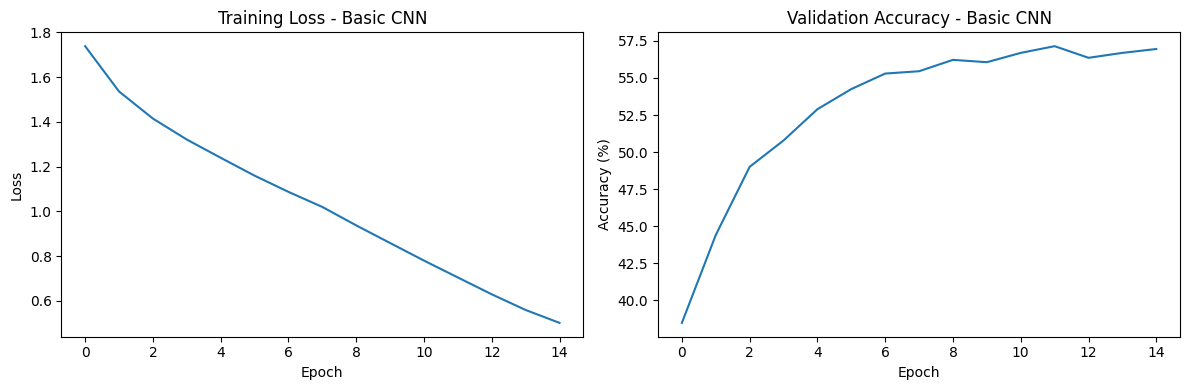

Best validation accuracy: 57.14%


In [8]:
# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_accuracies

# Initialize and train basic model
print("Training Basic CNN Model...")
basic_model = BasicCNN().to(device)
print(f"Model parameters: {sum(p.numel() for p in basic_model.parameters()):,}")

basic_train_losses, basic_val_accuracies = train_model(basic_model, train_loader, val_loader, num_epochs=15)

# Plot training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(basic_train_losses)
plt.title('Training Loss - Basic CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(basic_val_accuracies)
plt.title('Validation Accuracy - Basic CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

print(f"Best validation accuracy: {max(basic_val_accuracies):.2f}%")

Validation Accuracy: 0.5695

Classification Report:
              precision    recall  f1-score   support

       Angry       0.46      0.46      0.46       799
     Disgust       0.69      0.44      0.54        87
        Fear       0.50      0.35      0.41       820
       Happy       0.73      0.79      0.76      1443
         Sad       0.42      0.49      0.45       966
    Surprise       0.74      0.71      0.72       634
     Neutral       0.51      0.52      0.51       993

    accuracy                           0.57      5742
   macro avg       0.58      0.54      0.55      5742
weighted avg       0.57      0.57      0.57      5742



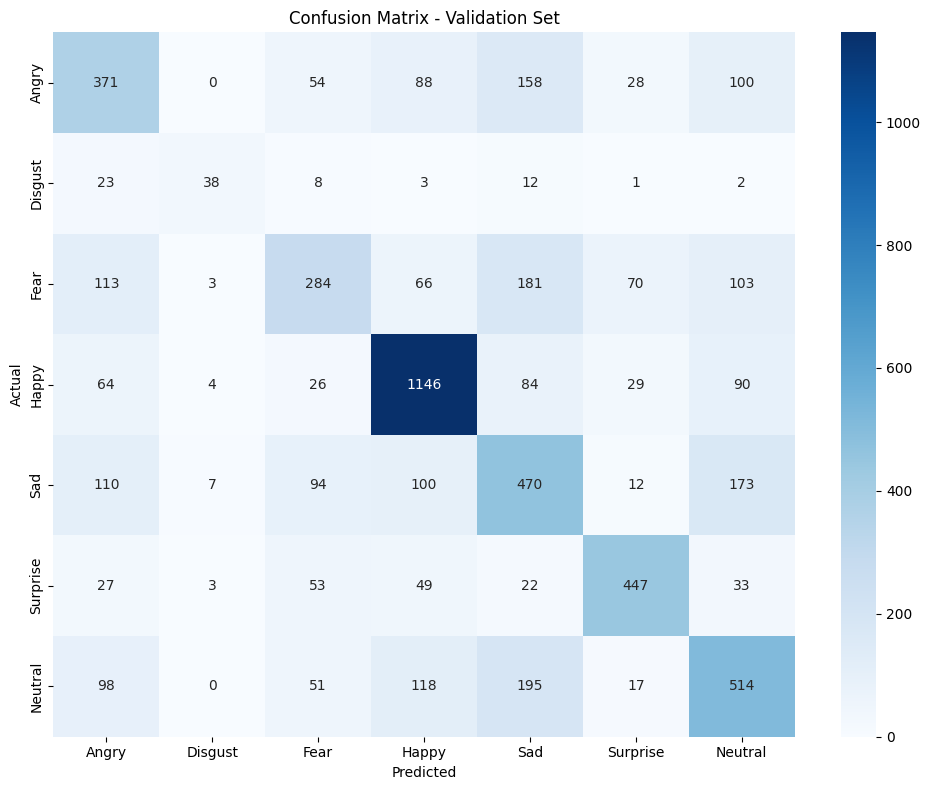

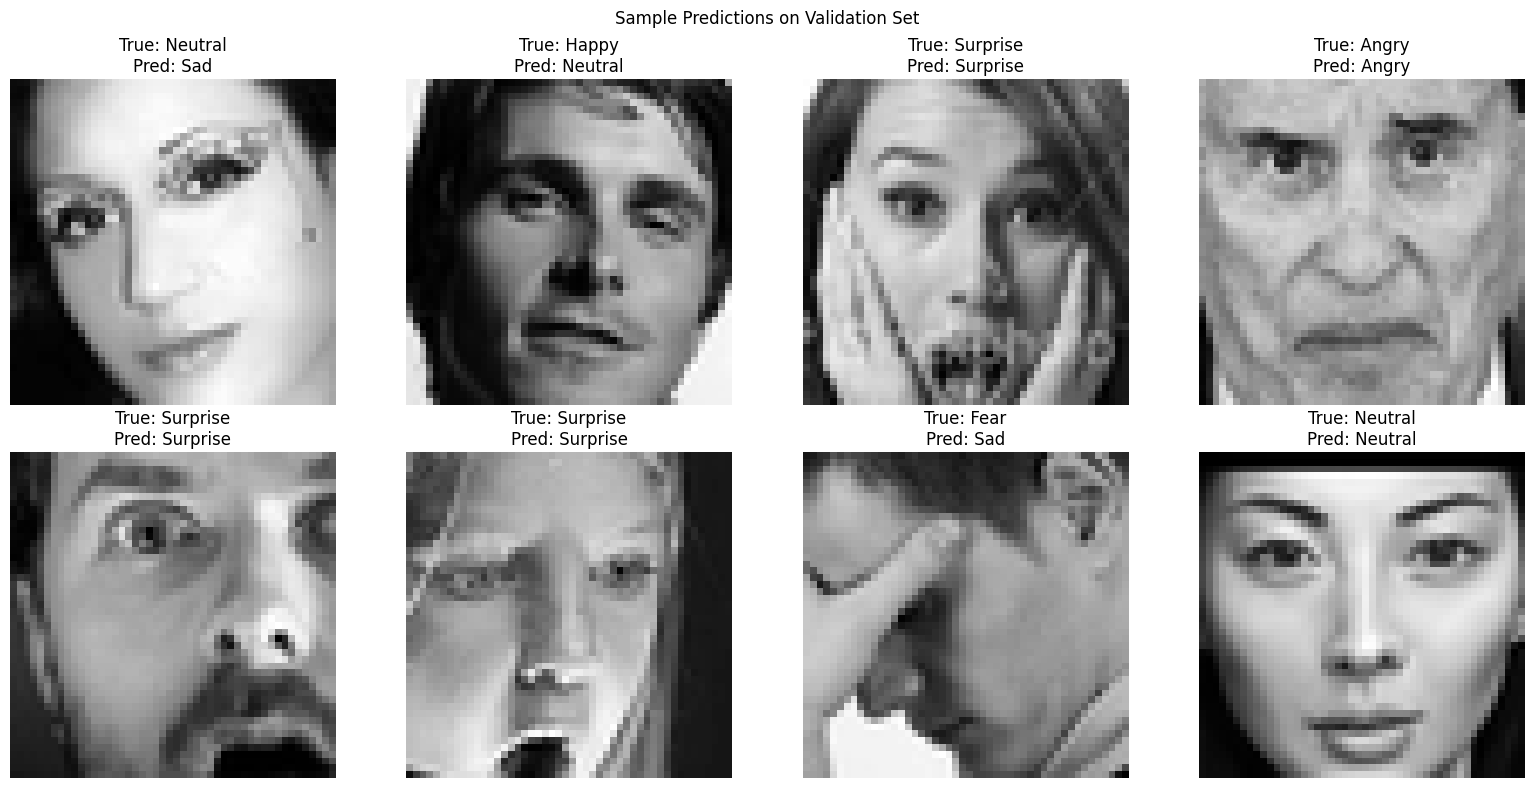

In [11]:
# Cell 8: Evaluate model on validation set
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(target.numpy())

    return np.array(predictions), np.array(true_labels)

# Get predictions on validation set
val_predictions, val_true = get_predictions(basic_model, val_loader, device)

# Calculate accuracy
val_accuracy = accuracy_score(val_true, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
class_names = [emotion_labels[i] for i in range(7)]
print(classification_report(val_true, val_predictions, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(val_true, val_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Show some validation examples with predictions
def show_predictions(model, dataset, indices, device, num_samples=8):
    model.eval()
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    with torch.no_grad():
        for i, idx in enumerate(indices[:num_samples]):
            image, true_label = dataset[idx]
            image_batch = image.unsqueeze(0).to(device)
            output = model(image_batch)
            _, predicted = torch.max(output, 1)

            row = i // 4
            col = i % 4

            # Convert image back to numpy for display
            img_display = image.squeeze().cpu().numpy()
            # Denormalize
            img_display = (img_display + 1) / 2

            axes[row, col].imshow(img_display, cmap='gray')
            axes[row, col].set_title(f'True: {emotion_labels[true_label.item()]}\n'
                                   f'Pred: {emotion_labels[predicted.item()]}')
            axes[row, col].axis('off')

    plt.suptitle('Sample Predictions on Validation Set')
    plt.tight_layout()
    plt.show()

# Show some validation predictions
sample_indices = np.random.choice(len(val_dataset), 8, replace=False)
show_predictions(basic_model, val_dataset, sample_indices, device)

In [12]:
import wandb

# Start a new wandb run to track this model
run = wandb.init(
    # Set your wandb entity (replace with your username)
    entity="zeliz22-free-university-of-tbilisi-",
    # Set the wandb project
    project="Facial Expression Recognition Challenge",
    name="CNN-Base_Model",
    # Add tags to organize runs
    tags=["CNN", "facial-expression", "pytorch", "base-model"],
    # Track hyperparameters and run metadata
    config={
        "architecture": "CNN",
        "dataset": "FER2013",
        "epochs": 15,
        "batch_size": 64,
        "image_size": "48x48",
    }
)

# Count model parameters
total_params = sum(p.numel() for p in basic_model.parameters())
trainable_params = sum(p.numel() for p in basic_model.parameters() if p.requires_grad)

# Log the final model results based on your training output
run.log({
    "final_train_accuracy": 0.59,  # From your results: Train Acc: 60.90%
    "final_train_loss": 0.6,     # From your results: Train Loss: 1.0504
    "final_val_accuracy": 0.57,    # From your results: Val Acc: 62.03%
    "final_val_loss": 0.6,       # From your results: Val Loss: 1.0073
    "total_parameters": total_params,
    "trainable_parameters": trainable_params,
    "steps_per_epoch": len(train_loader),  # 359 batches as shown in your output
})

# Finish the run
run.finish()

print("Model results logged to WandB successfully!")

wandb: Currently logged in as: zeliz22 (zeliz22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


final_train_accuracy,▁
final_train_loss,▁
final_val_accuracy,▁
final_val_loss,▁
steps_per_epoch,▁
total_parameters,▁
trainable_parameters,▁
final_train_accuracy,0.59
final_train_loss,0.6
final_val_accuracy,0.57
final_val_loss,0.6


Model results logged to WandB successfully!
